In [88]:
#Import des csv

import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
import warnings

# Traitement des données

In [89]:
warnings.filterwarnings("ignore")

crypto_prices = pd.read_csv("crypto_prices_v2.csv")
# Convert timestamp column to datetime format
crypto_prices['timestamp'] = pd.to_datetime(crypto_prices['timestamp'])

# Set timestamp column as index
crypto_prices.set_index('timestamp', inplace=True)
crypto_prices.head()

,unfi-busd,iota-usd,bhp-usdt,dot-usdt,aave-usdt,nmc-usdt,mx-usdt,dht-usdt,crv-usd,pha-usdt,...,api3-usdt,1inch-usdt,comp-usdt,ersdl-usdt,xor-usdt,ren-usdt,bid-usdt,mkr-usdt,prq-usdt,mta-usdt
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01,5.562509,0.294552,0.664400,8.798804,87.590000,0.439790,0.1436,0.859310,0.637000,0.118509,...,1.801849,1.167545,144.668659,0.008365,102.525652,0.327979,0.013622,589.914791,0.527962,0.909049
2021-01-02,5.221067,0.286993,0.667342,8.760201,85.937751,0.459137,0.1452,0.992900,0.592534,0.117040,...,1.834821,1.090871,140.000168,0.008287,98.931513,0.312595,0.013083,597.494350,0.460791,1.011624
2021-01-03,6.482086,0.298317,0.667600,9.279673,87.968375,0.507415,0.1388,0.959000,0.621000,0.115557,...,1.889542,1.084320,145.591570,0.009397,101.388139,0.325757,0.014231,672.198175,0.507648,1.160168
2021-01-04,5.851341,0.317800,0.660000,9.465044,102.336182,0.521261,0.1384,1.057248,0.672000,0.114000,...,2.175675,1.076138,145.562839,0.012118,110.576618,0.329471,0.013833,678.422680,0.451232,1.165947
2021-01-05,5.751700,0.354807,0.652600,9.612824,114.077356,0.510710,0.1376,1.171523,0.680000,0.115772,...,2.388763,1.141967,155.225308,0.012469,115.365119,0.335810,0.012865,705.739433,0.608839,1.199186


In [90]:
exchange_info = pd.read_csv("exchange_info_v2.csv")

In [91]:
crix = pd.read_csv("crix.csv", delimiter=";")
crix['date'] = pd.to_datetime(crix['date'])

In [92]:
data_factors = pd.read_csv("data_factors.csv", delimiter=";", header=4)
data_factors = data_factors.rename(columns={data_factors.columns[0]: 'timestamp'})
data_factors = data_factors.iloc[:-1]
# Convert timestamp column to datetime format
data_factors['timestamp'] = pd.to_datetime(data_factors['timestamp'])


In [93]:
momentum_daily = pd.read_csv("momentum_daily.csv", delimiter=";", header=13)
momentum_daily.fillna(0, inplace=True)
momentum_daily = momentum_daily.iloc[:, :-2]

# Convert date column to timestamp format
momentum_daily = momentum_daily.rename(columns={momentum_daily.columns[0]: 'timestamp'})
momentum_daily = momentum_daily.iloc[:-2]
momentum_daily['timestamp'] = pd.to_datetime(momentum_daily['timestamp'])

# Implémentation des différents algorithmes


### I) GetPortfolioCompo

In [94]:

rebalancing_dates = pd.date_range(start=crypto_prices.index.min(), end=crypto_prices.index.max(), freq='MS')
rebalancing_dates = rebalancing_dates[1:]
def get_portfolio_compo(df, rebalancing_dates, portfolio_index, horizon):
    portfolio_data = []
    
    for date in rebalancing_dates:
        portfolios = {}
        for i in range(portfolio_index):
            # Sélectionner les données de marché pour la date de rééquilibrage
            market_data = df.loc[date]
            
            # Calculer les rendements sur l'horizon spécifié
            returns = (market_data - df.shift(periods=horizon).loc[date]) / df.shift(periods=horizon).loc[date]
            
            # Classer les cryptomonnaies en fonction des rendements décroissants
            ranked_cryptos = returns.sort_values(ascending=False)
            
            # Extraire les noms des cryptomonnaies pour le portefeuille i+1
            portfolio = ranked_cryptos.iloc[i * 10: (i + 1) * 10]
            
            # Ajouter les noms et les rendements des cryptomonnaies au portefeuille
            portfolio_with_returns = [crypto_name for crypto_name, return_value in portfolio.items()]
            portfolios[f"Portfolio_{i+1}"] = portfolio_with_returns
            
        portfolio_data.append(portfolios)
    
    # Créer un DataFrame à partir des données de portefeuille
    portfolio_df = pd.DataFrame(portfolio_data, index=rebalancing_dates)
    
    return portfolio_df

# Supposons que vous voulez le portefeuille P1 à chaque date de rééquilibrage avec un horizon de 1 jour
portfolios_df = get_portfolio_compo(crypto_prices, rebalancing_dates, portfolio_index=9, horizon=15)


### II) ComputePortfolioValues, UpdateCmpo et UpdateValue

In [95]:
def UpdateValue(date, crypto_prices, portfolio_compo, initial_value):
    if len(portfolio_compo) == 0:
        return initial_value
    portfolio_value = (crypto_prices.loc[date, list(portfolio_compo.keys())] * list(portfolio_compo.values())).sum()
    return portfolio_value


def UpdateCompo(date, portfolio_index, portfolio_compo, portfolio_value, portfolios_df, crypto_prices):
    portfolio_compo.clear()
    portefeuille_actuelle = portfolios_df.loc[date, f"Portfolio_{portfolio_index}"]
    portfolio_compo.update({crypto_name: portfolio_value / (10 * crypto_prices.loc[date, crypto_name]) for crypto_name in portefeuille_actuelle})


def compute_portfolio_values(crypto_prices,portfolios_df, rebalancing_dates, portfolio_index, horizon, initial_value):
    portfolio_compo = {}
    portfolio_values = [initial_value]
    portfolio_value = initial_value

    for date in crypto_prices.index:
        portfolio_value = UpdateValue(date, crypto_prices, portfolio_compo, initial_value)
        if date in rebalancing_dates:
            UpdateCompo(date, portfolio_index, portfolio_compo, portfolio_value, portfolios_df, crypto_prices)
        portfolio_values.append(portfolio_value)

    return portfolio_values





# Etude des portefeuilles 1 à 9

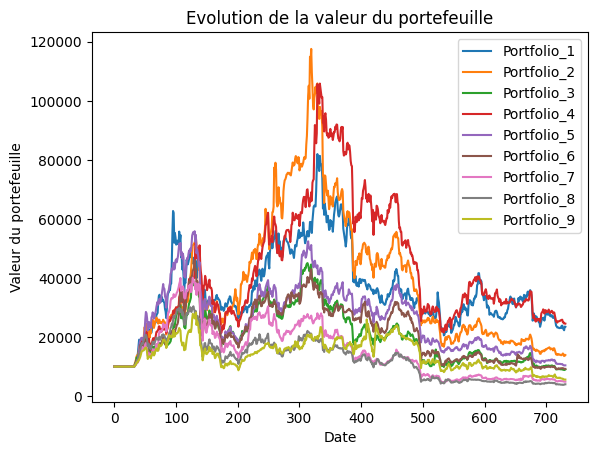

In [96]:


# Initialiser la valeur initiale du portefeuille
initial_portfolio_value = 10000  # Par exemple, 10000 USD

# Indices de portefeuille à considérer
portfolio_indices = range(1, 10)

# Calculer les valeurs des portefeuilles pour les dates de rééquilibrage
portfolio_values_dict = {}


for portfolio_index in portfolio_indices:
    portfolio_values = compute_portfolio_values(crypto_prices,portfolios_df, rebalancing_dates, portfolio_index, horizon=15, initial_value=initial_portfolio_value)
    portfolio_values_dict[f"Portfolio_{portfolio_index}"] = portfolio_values
portfolio_values_df = pd.DataFrame(portfolio_values_dict)

# Afficher les graphiques pour chaque indice de portefeuille
for portfolio_index, portfolio_values in portfolio_values_dict.items():
    plt.plot(portfolio_values, label=portfolio_index)

plt.title('Evolution de la valeur du portefeuille')
plt.xlabel('Date')
plt.ylabel('Valeur du portefeuille')
plt.legend()
plt.show()

### Daily returns

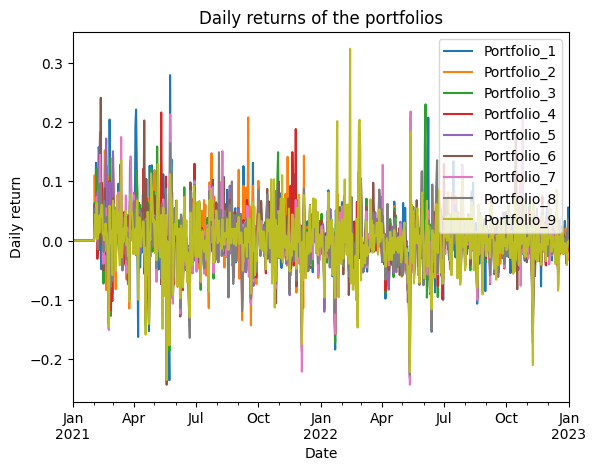

In [97]:
#on drop les nan
portfolio_values_df = portfolio_values_df.dropna()
#on drop la premiere ligne de portfolio_values_df
portfolio_values_df = portfolio_values_df.iloc[1:]
#on rajoute les timestamp de crypto_prices comme index de portfolio_values_df
portfolio_values_df.index = crypto_prices.index


portfolio_daily_returns = portfolio_values_df.pct_change()
portfolio_daily_returns.plot(title='Daily returns of the portfolios', xlabel='Date', ylabel='Daily return')
plt.show()



### Creation de dataframe contenant RF pour chaque timestamp de cryptoprices afin de faciliter les calculs de ratio de sharpe.

In [98]:
first_date = data_factors['timestamp'].min()
last_date = crypto_prices.index.max()

all_dates = pd.date_range(start=first_date, end=last_date, freq='D')
rf_df = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')
rf_df['RF'].fillna(method='ffill', inplace=True)
rf_df['RF'] = rf_df['RF'].str.replace(',', '.').astype(float)/100 

merged_df = portfolio_daily_returns.merge(rf_df, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_df = merged_df.loc[rebalancing_dates[0]:]
merged_df = merged_df.iloc[1:]
variance_merged = merged_df.std()


### Statistiques sur les daily returns

In [99]:
# Compute the indicators for each returns series
indicators = {}

for column in merged_df.columns:
    returns = merged_df[column]
    result = returns.describe()
    skewness = sm.stats.stattools.robust_skewness(returns)
    kurtosis = sm.stats.stattools.robust_kurtosis(returns)
    
    indicators[column] = {
        'Mean': result['mean'],
        'Stddev': result['std'],
        'Median': result['50%'],
        'Min': result['min'],
        'Max': result['max'],
        'Skewness': skewness[0],
        'Kurtosis': kurtosis[0]
    }

# Print the indicators for each returns series
for column, values in indicators.items():
    print(f"Indicators for {column}:")
    for indicator, value in values.items():
        print(f"{indicator}: {value}")
    print()

Indicators for Portfolio_1:
Mean: 0.0024189755428441623
Stddev: 0.04909171023676607
Median: 0.00044979488285279423
Min: -0.2354454012165209
Max: 0.27904042829100795
Skewness: 0.35327548213087545
Kurtosis: 4.534457832069984

Indicators for Portfolio_2:
Mean: 0.0015421065537396539
Stddev: 0.04610495381703023
Median: 0.002020784381006502
Min: -0.23399131987880273
Max: 0.2079784041952406
Skewness: -0.16798598793805183
Kurtosis: 2.663403491830193

Indicators for Portfolio_3:
Mean: 0.0008975287440794944
Stddev: 0.04537432510338965
Median: 0.0013356182989860965
Min: -0.20423867559770226
Max: 0.22977989445527802
Skewness: -0.27138779999522405
Kurtosis: 3.439491807244904

Indicators for Portfolio_4:
Mean: 0.0022482924202351863
Stddev: 0.043802916095904185
Median: 0.0027760074353029296
Min: -0.173569784239326
Max: 0.21609208940337776
Skewness: -0.06198672151397107
Kurtosis: 2.7934979474108896

Indicators for Portfolio_5:
Mean: 0.0009571849867231523
Stddev: 0.04212976575367125
Median: 0.002613988

In [100]:
#on soustrait RF à chaque daily return
merged_df['Portfolio_1'] = merged_df['Portfolio_1'] - merged_df['RF']
merged_df['Portfolio_2'] = merged_df['Portfolio_2'] - merged_df['RF']
merged_df['Portfolio_3'] = merged_df['Portfolio_3'] - merged_df['RF']
merged_df['Portfolio_4'] = merged_df['Portfolio_4'] - merged_df['RF']
merged_df['Portfolio_5'] = merged_df['Portfolio_5'] - merged_df['RF']
merged_df['Portfolio_6'] = merged_df['Portfolio_6'] - merged_df['RF']
merged_df['Portfolio_7'] = merged_df['Portfolio_7'] - merged_df['RF']
merged_df['Portfolio_8'] = merged_df['Portfolio_8'] - merged_df['RF']
merged_df['Portfolio_9'] = merged_df['Portfolio_9'] - merged_df['RF']


### Ratio de Sharpe

In [101]:
#on calcul le ration de sharpe pour chaque portfolio de 1 a 9
sharpe_ratios_portfolios = (merged_df.mean()) / variance_merged
print("Le ratio de sharpe des portefeuilles 1 à 9 :","\n",sharpe_ratios_portfolios[0:9])

Le ratio de sharpe des portefeuilles 1 à 9 : 
 Portfolio_1    0.048674
Portfolio_2    0.032808
Portfolio_3    0.019130
Portfolio_4    0.050654
Portfolio_5    0.022020
Portfolio_6    0.018930
Portfolio_7    0.001003
Portfolio_8   -0.007895
Portfolio_9    0.008511
dtype: float64


### Calcul des ratio des Treynor / alpha de Jensen.

In [102]:

mkt_RF_df = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF']], on='timestamp', how='left')
mkt_RF_df['Mkt-RF'].fillna(method='ffill', inplace=True)
mkt_RF_df['Mkt-RF'] = mkt_RF_df['Mkt-RF'].str.replace(',', '.').astype(float)/100

merged_mkt_RF_df = merged_df.merge(mkt_RF_df, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_mkt_RF_df = merged_mkt_RF_df.loc[rebalancing_dates[0]:]
merged_mkt_RF_df = merged_mkt_RF_df.iloc[1:]

merged_mkt_RF_df.head()

,Portfolio_1,Portfolio_2,Portfolio_3,Portfolio_4,Portfolio_5,Portfolio_6,Portfolio_7,Portfolio_8,Portfolio_9,RF,Mkt-RF
timestamp,,,,,,,,,,,
2021-02-03,0.060593,0.041370,0.056166,0.039222,0.024428,0.026546,0.023094,0.054111,0.044119,0.0,0.0015
2021-02-04,0.131356,0.082706,0.041686,0.030821,0.025813,0.033574,0.018965,0.012805,0.009756,0.0,0.0123
2021-02-05,0.026753,0.080680,0.121114,0.075505,0.080087,0.067547,0.073394,0.036248,0.063519,0.0,0.0058
2021-02-06,0.068679,0.027178,-0.001297,-0.030620,0.048970,0.013618,-0.001443,0.063680,0.002718,0.0,0.0058
2021-02-07,0.078834,0.002044,0.001293,-0.009741,-0.009109,-0.000523,0.006110,-0.014703,0.021444,0.0,0.0058


### Regression pour obtenir les betas et alphas de Jensen

In [103]:

# Perform the regression for each portfolio
for portfolio_index in range(1, 10):
    # Select the portfolio values and the Mkt-RF column
    X = merged_mkt_RF_df['Mkt-RF']
    y = merged_mkt_RF_df[f'Portfolio_{portfolio_index}']
    
    # Add a constant term to the independent variable
    X = sm.add_constant(X)
    
    # Fit the linear regression model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Get the intercept (alpha) and slope (beta) coefficients
    alpha = results.params[0]
    beta = results.params[1]
    
    # Print the alpha and beta coefficients
    print(f'Portfolio_{portfolio_index}:')
    print(f'Alpha (Jensen): {alpha}')
    print(f'Beta (Market): {beta}')
    print()

Portfolio_1:
Alpha (Jensen): 0.002211051965643519
Beta (Market): 0.9668945659725882

Portfolio_2:
Alpha (Jensen): 0.0012218331155011012
Beta (Market): 0.8631491632186671

Portfolio_3:
Alpha (Jensen): 0.0006644494806484474
Beta (Market): 0.7247641113387633

Portfolio_4:
Alpha (Jensen): 0.002057938243443774
Beta (Market): 0.72863776374779

Portfolio_5:
Alpha (Jensen): 0.0007752319798164464
Beta (Market): 0.6985207364816501

Portfolio_6:
Alpha (Jensen): 0.0006241096234047731
Beta (Market): 0.7716782988465907

Portfolio_7:
Alpha (Jensen): -0.00013394788592596563
Beta (Market): 0.9298103120554839

Portfolio_8:
Alpha (Jensen): -0.0005540491522037425
Beta (Market): 0.8879396501442148

Portfolio_9:
Alpha (Jensen): 0.00024568374310872566
Beta (Market): 1.0151355577082932



### Ratio de Treynor

In [104]:

#on calcul le ration de sharpe pour chaque portfolio de 1 a 9
treynor_ratios_portfolios = (merged_df.mean()) / beta
print("Le ratio de treynor des portefeuilles 1 à 9 sont :","\n",treynor_ratios_portfolios[0:9])

Le ratio de treynor des portefeuilles 1 à 9 sont : 
 Portfolio_1    0.002354
Portfolio_2    0.001490
Portfolio_3    0.000855
Portfolio_4    0.002186
Portfolio_5    0.000914
Portfolio_6    0.000819
Portfolio_7    0.000046
Portfolio_8   -0.000342
Portfolio_9    0.000424
dtype: float64


### Simulation de FAMA & FRENCH

In [105]:
fm_portfolios = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF','HML','SMB']], on='timestamp', how='left')
fm_portfolios['Mkt-RF'].fillna(method='ffill', inplace=True)
fm_portfolios['Mkt-RF'] = fm_portfolios['Mkt-RF'].str.replace(',', '.').astype(float)/100
fm_portfolios['HML'].fillna(method='ffill', inplace=True)
fm_portfolios['HML'] = fm_portfolios['HML'].str.replace(',', '.').astype(float)/100
fm_portfolios['SMB'].fillna(method='ffill', inplace=True)
fm_portfolios['SMB'] = fm_portfolios['SMB'].str.replace(',', '.').astype(float)/100

fm_portfolios = merged_df.merge(fm_portfolios, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
fm_portfolios = fm_portfolios.loc[rebalancing_dates[0]:]
fm_portfolios.head()


,Portfolio_1,Portfolio_2,Portfolio_3,Portfolio_4,Portfolio_5,Portfolio_6,Portfolio_7,Portfolio_8,Portfolio_9,RF,Mkt-RF,HML,SMB
timestamp,,,,,,,,,,,,,
2021-02-02,0.021151,0.110044,0.063678,0.034783,0.030922,0.061237,0.024386,0.047010,0.018269,0.0,0.0148,-0.0108,-0.0085
2021-02-03,0.060593,0.041370,0.056166,0.039222,0.024428,0.026546,0.023094,0.054111,0.044119,0.0,0.0015,0.0070,0.0043
2021-02-04,0.131356,0.082706,0.041686,0.030821,0.025813,0.033574,0.018965,0.012805,0.009756,0.0,0.0123,0.0037,0.0038
2021-02-05,0.026753,0.080680,0.121114,0.075505,0.080087,0.067547,0.073394,0.036248,0.063519,0.0,0.0058,-0.0047,0.0107
2021-02-06,0.068679,0.027178,-0.001297,-0.030620,0.048970,0.013618,-0.001443,0.063680,0.002718,0.0,0.0058,-0.0047,0.0107


In [107]:

# Select the independent variables (Mkt-RF, SMB, HML)
X = fm_portfolios[['Mkt-RF', 'SMB', 'HML']]

# Select the dependent variables (portfolio returns)
y = fm_portfolios[['Portfolio_1', 'Portfolio_2', 'Portfolio_3', 'Portfolio_4', 'Portfolio_5', 'Portfolio_6', 'Portfolio_7', 'Portfolio_8', 'Portfolio_9']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Select each portfolio as a dependent variable and perform OLS regression
coefficients = {}
alphas = {}

for portfolio in y.columns:
    # Select the current portfolio as the dependent variable
    current_y = y[portfolio]

    # Perform OLS regression
    model = sm.OLS(current_y, X)
    results = model.fit()

    # Get the coefficients
    Bmarket = results.params['Mkt-RF']
    Bsmb = results.params['SMB']
    Bhml = results.params['HML']

    # Get the alpha (intercept)
    alpha = results.params['const']

    # Store coefficients and alpha in dictionaries
    coefficients[portfolio] = {'Bmarket': Bmarket, 'Bsmb': Bsmb, 'Bhml': Bhml}
    alphas[portfolio] = alpha

# Print the coefficients and alphas for each portfolio
print("Coefficients:")
for portfolio, coeffs in coefficients.items():
    print(f"{portfolio}: Bmarket={coeffs['Bmarket']}, Bsmb={coeffs['Bsmb']}, Bhml={coeffs['Bhml']}")

print("\nAlphas:")
for portfolio, alpha in alphas.items():
    print(f"{portfolio}: Alpha={alpha}")


Coefficients:
Portfolio_1: Bmarket=0.961501598136943, Bsmb=0.3386565420854252, Bhml=0.1523865755762788
Portfolio_2: Bmarket=0.8988204026970165, Bsmb=-0.003076044116250784, Bhml=0.06741455974486985
Portfolio_3: Bmarket=0.7401957600397763, Bsmb=0.00881385068594252, Bhml=0.030466685721396217
Portfolio_4: Bmarket=0.7762491242776941, Bsmb=-0.12414204804965315, Bhml=0.06725971211621647
Portfolio_5: Bmarket=0.6892136830344119, Bsmb=0.1484986630421088, Bhml=0.0405720089702994
Portfolio_6: Bmarket=0.7970888501534195, Bsmb=-0.15314776212462597, Bhml=-0.02078956105174091
Portfolio_7: Bmarket=0.9427518630452788, Bsmb=-0.0814378599373918, Bhml=-0.0072823761154558134
Portfolio_8: Bmarket=0.9407711446358734, Bsmb=-0.24642929482987236, Bhml=0.016681216833179163
Portfolio_9: Bmarket=1.0720521800696237, Bsmb=-0.04226341823265052, Bhml=0.14171557836175208

Alphas:
Portfolio_1: Alpha=0.00212010236296028
Portfolio_2: Alpha=0.0012739655921453897
Portfolio_3: Alpha=0.0007031946612244024
Portfolio_4: Alpha=0.

In [ ]:

# Création d'un DataFrame vide pour les cryptomonnaies centralisées
centralized_df = pd.DataFrame()

# Liste des noms de cryptomonnaies centralisées
centralized_crypto_names = exchange_info[exchange_info['CeX'] == True]['Unnamed: 0'].values

# Parcourir les colonnes du DataFrame crypto_prices
for crypto in crypto_prices.columns:
    # Vérifier si la cryptomonnaie est centralisée
    if crypto in centralized_crypto_names:
        # Ajouter la cryptomonnaie au DataFrame centralized_df
        centralized_df[crypto] = crypto_prices[crypto]

# on fait pareil pour les cryptomonnaies décentralisées
decentralized_df = pd.DataFrame()
decentralized_crypto_names = exchange_info[exchange_info['DeX'] == False]['Unnamed: 0'].values
for crypto in crypto_prices.columns:
    if crypto in decentralized_crypto_names:
        decentralized_df[crypto] = crypto_prices[crypto]
centralized_df.head()
    

,unfi-busd,iota-usd,bhp-usdt,dot-usdt,aave-usdt,nmc-usdt,mx-usdt,dht-usdt,crv-usd,pha-usdt,...,gala-usdt,api3-usdt,1inch-usdt,comp-usdt,ersdl-usdt,xor-usdt,ren-usdt,mkr-usdt,prq-usdt,mta-usdt
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01,5.562509,0.294552,0.664400,8.798804,87.590000,0.439790,0.1436,0.859310,0.637000,0.118509,...,0.001185,1.801849,1.167545,144.668659,0.008365,102.525652,0.327979,589.914791,0.527962,0.909049
2021-01-02,5.221067,0.286993,0.667342,8.760201,85.937751,0.459137,0.1452,0.992900,0.592534,0.117040,...,0.001151,1.834821,1.090871,140.000168,0.008287,98.931513,0.312595,597.494350,0.460791,1.011624
2021-01-03,6.482086,0.298317,0.667600,9.279673,87.968375,0.507415,0.1388,0.959000,0.621000,0.115557,...,0.001182,1.889542,1.084320,145.591570,0.009397,101.388139,0.325757,672.198175,0.507648,1.160168
2021-01-04,5.851341,0.317800,0.660000,9.465044,102.336182,0.521261,0.1384,1.057248,0.672000,0.114000,...,0.001310,2.175675,1.076138,145.562839,0.012118,110.576618,0.329471,678.422680,0.451232,1.165947
2021-01-05,5.751700,0.354807,0.652600,9.612824,114.077356,0.510710,0.1376,1.171523,0.680000,0.115772,...,0.001525,2.388763,1.141967,155.225308,0.012469,115.365119,0.335810,705.739433,0.608839,1.199186


### Etude du portefeuille long sur 1 et short sur 9

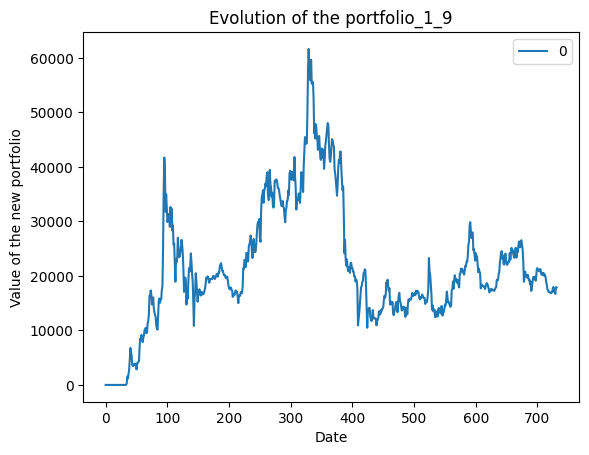

In [136]:
# Get the values of Portfolio 1 and the last portfolio
portfolio_1_values = portfolio_values_dict["Portfolio_1"]
last_portfolio_values = portfolio_values_dict[f"Portfolio_{len(portfolio_values_dict)}"]

# Create a new portfolio that buys Portfolio 1 and sells the last portfolio
portfolio_1_9 = pd.Series(portfolio_1_values) - pd.Series(last_portfolio_values)
#on convertit portfolio_1_9 en dataframe
portfolio_1_9 = pd.DataFrame(portfolio_1_9)
# Plot the values of all portfolios
portfolio_values_df = pd.DataFrame(portfolio_values_dict)
# Plot the new portfolio values P1_9
portfolio_1_9.plot(title='Evolution of the portfolio_1_9', xlabel='Date', ylabel='Value of the new portfolio')
plt.show()


### Daily returns

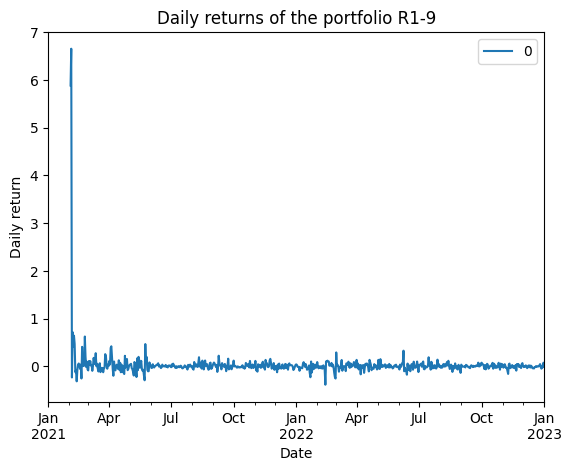

In [137]:
portfolio_1_9 = portfolio_1_9.iloc[1:]
portfolio_1_9.index = crypto_prices.index
portfolio_1_9_daily_returns = portfolio_1_9.pct_change()
portfolio_1_9_daily_returns.plot(title='Daily returns of the portfolio R1-9', xlabel='Date', ylabel='Daily return')
plt.show()

On fait R-Rf pour faciliter les calculs suivants

In [145]:
rf_df_1_9 = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')
rf_df_1_9['RF'].fillna(method='ffill', inplace=True)
rf_df_1_9['RF'] = rf_df_1_9['RF'].str.replace(',', '.').astype(float)/100

merged_df_1_9 = portfolio_1_9_daily_returns.merge(rf_df_1_9, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_df_1_9 = merged_df_1_9.loc[rebalancing_dates[0]:]
merged_df_1_9 = merged_df_1_9.iloc[2:]
variance_merged_1_9 = merged_df_1_9.std()
merged_df_1_9[0] = merged_df_1_9[0] - merged_df_1_9['RF']
merged_df_1_9.head()

,0,RF
timestamp,,
2021-02-03,5.880045,0.0
2021-02-04,6.650282,0.0
2021-02-05,-0.233401,0.0
2021-02-06,0.716195,0.0
2021-02-07,0.407996,0.0


### Simulation de FAMA & FRENCH

### Ratio de sharpe Portefeuille P1-9

In [146]:
sharpe_ratio_p1_9 = merged_df_1_9.mean() / variance_merged_1_9
print("Le ratio de sharpe du portefeuille P1-9 est :", sharpe_ratio_p1_9[0])

Le ratio de sharpe du portefeuille P1-9 est : 0.0727745536022349


In [147]:
mkt_RF_df_1_9 = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF']], on='timestamp', how='left')
mkt_RF_df_1_9['Mkt-RF'].fillna(method='ffill', inplace=True)
mkt_RF_df_1_9['Mkt-RF'] = mkt_RF_df_1_9['Mkt-RF'].str.replace(',', '.').astype(float)/100

merged_mkt_RF_df_1_9 = portfolio_1_9_daily_returns.merge(mkt_RF_df_1_9, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_mkt_RF_df_1_9 = merged_mkt_RF_df_1_9.loc[rebalancing_dates[0]:]
merged_mkt_RF_df_1_9 = merged_mkt_RF_df_1_9.iloc[2:]

### Simulation Alpha de Jensen

In [148]:
# Select the portfolio values and the Mkt-RF column
X = merged_mkt_RF_df_1_9['Mkt-RF']
y = merged_mkt_RF_df_1_9[0]

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Get the intercept (alpha) and slope (beta) coefficients
alpha_1_9 = results.params[0]
beta_1_9 = results.params[1]

# Print the alpha and beta coefficients
print(f'Portfolio_1_9:')
print(f'Alpha (Jensen): {alpha_1_9}')
print(f'Beta (Market): {beta_1_9}')
print()

Portfolio_1_9:
Alpha (Jensen): 0.02506597073992868
Beta (Market): 1.698598754495311



### Ratio de Treynor

In [149]:
#on calcul le ration de sharpe pour le portefeuille P1-9
treynor_ratios_1_9_portfolio = (merged_mkt_RF_df_1_9.mean() ) / beta_1_9
print("Le ratio de treynor des portefeuilles 1 à 9 sont :","\n",treynor_ratios_1_9_portfolio[0])

Le ratio de treynor des portefeuilles 1 à 9 sont : 
 0.014913585708305185


### Simulation FAMA FRENCH

In [158]:
fm_portfolio_1_9 = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF','HML','SMB']], on='timestamp', how='left')
fm_portfolio_1_9['Mkt-RF'].fillna(method='ffill', inplace=True)
fm_portfolio_1_9['Mkt-RF'] = fm_portfolio_1_9['Mkt-RF'].str.replace(',', '.').astype(float)/100
fm_portfolio_1_9['HML'].fillna(method='ffill', inplace=True)
fm_portfolio_1_9['HML'] = fm_portfolio_1_9['HML'].str.replace(',', '.').astype(float)/100
fm_portfolio_1_9['SMB'].fillna(method='ffill', inplace=True)
fm_portfolio_1_9['SMB'] = fm_portfolio_1_9['SMB'].str.replace(',', '.').astype(float)/100

fm_portfolio_1_9 = merged_df_1_9.merge(fm_portfolio_1_9, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
fm_portfolio_1_9 = fm_portfolio_1_9.loc[rebalancing_dates[0]:]
X = fm_portfolio_1_9[['Mkt-RF', 'SMB', 'HML']]

fm_portfolio_1_9.head()


,0,RF,Mkt-RF,HML,SMB
timestamp,,,,,
2021-02-03,5.880045,0.0,0.0015,0.0070,0.0043
2021-02-04,6.650282,0.0,0.0123,0.0037,0.0038
2021-02-05,-0.233401,0.0,0.0058,-0.0047,0.0107
2021-02-06,0.716195,0.0,0.0058,-0.0047,0.0107
2021-02-07,0.407996,0.0,0.0058,-0.0047,0.0107


In [160]:

# Select the independent variables (Mkt-RF, SMB, HML)

# Select the dependent variables (portfolio returns)
y = fm_portfolio_1_9[0]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Select each portfolio as a dependent variable and perform OLS regression
coefficients = {}
alphas = {}


# Select the current portfolio as the dependent variable
current_y = y

# Perform OLS regression
model = sm.OLS(current_y, X)
results = model.fit()

# Get the coefficients
Bmarket = results.params['Mkt-RF']
Bsmb = results.params['SMB']
Bhml = results.params['HML']

# Get the alpha (intercept)
alpha = results.params['const']

# Store coefficients and alpha in dictionaries
coefficients[portfolio] = {'Bmarket': Bmarket, 'Bsmb': Bsmb, 'Bhml': Bhml}
alphas[portfolio] = alpha

# Print the coefficients and alphas for each portfolio
print("Coefficients:")
for portfolio, coeffs in coefficients.items():
    print(f"{portfolio}: Bmarket={coeffs['Bmarket']}, Bsmb={coeffs['Bsmb']}, Bhml={coeffs['Bhml']}")

print("\nAlphas:")
for portfolio, alpha in alphas.items():
    print(f"{portfolio}: Alpha={alpha}")


Coefficients:
Portfolio_8: Bmarket=1.7561116947888051, Bsmb=2.9302226234403106, Bhml=1.6474177539153108

Alphas:
Portfolio_8: Alpha=0.023730286665481073


# Etude de R1 - R9

### Daily returns

<AxesSubplot:title={'center':'Daily returns of the portfolio R1-R9'}, xlabel='Date', ylabel='Daily return'>

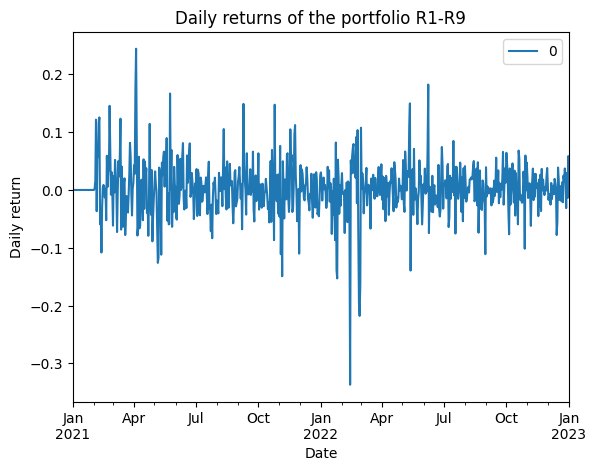

In [138]:
#on calcul et on affiche la difference de rentabilite entre le portefeuille 1 et le 9
portfolio_1_minus_9 = portfolio_daily_returns["Portfolio_1"] - portfolio_daily_returns["Portfolio_9"]
portfolio_1_minus_9 = pd.DataFrame(portfolio_1_minus_9)

portfolio_1_minus_9.index = crypto_prices.index
portfolio_1_minus_9.plot(title='Daily returns of the portfolio R1-R9', xlabel='Date', ylabel='Daily return')


In [139]:
first_date = data_factors['timestamp'].min()
last_date = crypto_prices.index.max()

all_dates = pd.date_range(start=first_date, end=last_date, freq='D')
rf_df = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')
rf_df['RF'].fillna(method='ffill', inplace=True)
rf_df['RF'] = rf_df['RF'].str.replace(',', '.').astype(float)/100 

merged_1_minus_9_df = portfolio_1_minus_9.merge(rf_df, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_1_minus_9_df = merged_1_minus_9_df.loc[rebalancing_dates[0]:]
merged_1_minus_9_df = merged_1_minus_9_df.iloc[1:]
#on rename la colonne
merged_1_minus_9_df = merged_1_minus_9_df.rename(columns={merged_1_minus_9_df.columns[0]: 'R1-R9'})
merged_1_minus_9_df.head()

,R1-R9,RF
timestamp,,
2021-02-02,0.002883,0.0
2021-02-03,0.016474,0.0
2021-02-04,0.121600,0.0
2021-02-05,-0.036766,0.0
2021-02-06,0.065962,0.0


### Statistiques sur les daily returns

In [135]:
# Compute the indicators for each returns series
indicators = {}

for column in merged_1_minus_9_df:
    returns = merged_1_minus_9_df[column]
    result = returns.describe()
    skewness = sm.stats.stattools.robust_skewness(returns)
    kurtosis = sm.stats.stattools.robust_kurtosis(returns)
    
    indicators[column] = {
        'Mean': result['mean'],
        'Stddev': result['std'],
        'Median': result['50%'],
        'Min': result['min'],
        'Max': result['max'],
        'Skewness': skewness[0],
        'Kurtosis': kurtosis[0]
    }

# Indicator for R1-R9
print("Indicators for R1-R9:")
for indicator, value in indicators['R1-R9'].items():
    print(f"{indicator}: {value}")
print()

Indicators for R1-R9:
Mean: 0.001959130224164338
Stddev: 0.047500854595714334
Median: 0.0020024965959515306
Min: -0.3367621098981606
Max: 0.244234996443078
Skewness: -0.4120878382974035
Kurtosis: 6.388701648656294



### Ratio de Sharpe

In [115]:
ratio_sharpe_portfolio_1_minus_9 = portfolio_1_minus_9.mean() / portfolio_1_minus_9.std()
print("Le ratio de Sharpe de portfolio_1_minus_9 est :", ratio_sharpe_portfolio_1_minus_9[0])


Le ratio de Sharpe de portfolio_1_minus_9 est : 0.04035864175686419


### Simulation ALpha de Jensen

In [116]:

mkt_RF_df_1_minus_9 = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF']], on='timestamp', how='left')
mkt_RF_df_1_minus_9['Mkt-RF'].fillna(method='ffill', inplace=True)
mkt_RF_df_1_minus_9['Mkt-RF'] = mkt_RF_df_1_minus_9['Mkt-RF'].str.replace(',', '.').astype(float)

merged_mkt_RF_df_1_minus_9 = portfolio_1_minus_9.merge(mkt_RF_df_1_minus_9, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_mkt_RF_df_1_minus_9 = merged_mkt_RF_df_1_minus_9.loc[rebalancing_dates[0]:]
merged_mkt_RF_df_1_minus_9 = merged_mkt_RF_df_1_minus_9.iloc[2:]

In [117]:
# Select the portfolio values and the Mkt-RF column
X = merged_mkt_RF_df_1_minus_9['Mkt-RF']
y = merged_mkt_RF_df_1_minus_9[0]

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Get the intercept (alpha) and slope (beta) coefficients
alpha_1_minus_9 = results.params[0]
beta_1_minus_9 = results.params[1]

# Print the alpha and beta coefficients
print(f'Portfolio_1_minus_9:')
print(f'Alpha (Jensen): {alpha_1_minus_9}')
print(f'Beta (Market): {beta_1_minus_9}')
print()


Portfolio_1_minus_9:
Alpha (Jensen): 0.001965368222534794
Beta (Market): -0.00048240991735705116



### Ratio de Treynor

In [118]:
#on calcul le ration de sharpe pour le portefeuille R1-R9
treynor_ratios_1_minus_9_portfolio = (merged_mkt_RF_df_1_minus_9.mean() ) / beta_1_minus_9
print("Le ratio de treynor du portefeuille 1 moins le portefeuile 9 :","\n",treynor_ratios_1_minus_9_portfolio[0])

Le ratio de treynor du portefeuille 1 moins le portefeuile 9 : 
 -4.058389289772023


### Simulation de Fama FRENCH

In [165]:
fm_portfolio_1_minus_9 = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF','HML','SMB']], on='timestamp', how='left')
fm_portfolio_1_minus_9['Mkt-RF'].fillna(method='ffill', inplace=True)
fm_portfolio_1_minus_9['Mkt-RF'] = fm_portfolio_1_minus_9['Mkt-RF'].str.replace(',', '.').astype(float)/100
fm_portfolio_1_minus_9['HML'].fillna(method='ffill', inplace=True)
fm_portfolio_1_minus_9['HML'] = fm_portfolio_1_minus_9['HML'].str.replace(',', '.').astype(float)/100
fm_portfolio_1_minus_9['SMB'].fillna(method='ffill', inplace=True)
fm_portfolio_1_minus_9['SMB'] = fm_portfolio_1_minus_9['SMB'].str.replace(',', '.').astype(float)/100

fm_portfolio_1_minus_9 = merged_1_minus_9_df.merge(fm_portfolio_1_minus_9, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
fm_portfolio_1_minus_9 = fm_portfolio_1_minus_9.loc[rebalancing_dates[0]:]
X = fm_portfolio_1_minus_9[['Mkt-RF', 'SMB', 'HML']]

fm_portfolio_1_minus_9.head()


,R1-R9,RF,Mkt-RF,HML,SMB
timestamp,,,,,
2021-02-02,0.002883,0.0,0.0148,-0.0108,-0.0085
2021-02-03,0.016474,0.0,0.0015,0.0070,0.0043
2021-02-04,0.121600,0.0,0.0123,0.0037,0.0038
2021-02-05,-0.036766,0.0,0.0058,-0.0047,0.0107
2021-02-06,0.065962,0.0,0.0058,-0.0047,0.0107


In [166]:

# Select the independent variables (Mkt-RF, SMB, HML)

# Select the dependent variables (portfolio returns)
y = fm_portfolio_1_minus_9['R1-R9']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Select each portfolio as a dependent variable and perform OLS regression
coefficients = {}
alphas = {}


# Select the current portfolio as the dependent variable
current_y = y

# Perform OLS regression
model = sm.OLS(current_y, X)
results = model.fit()

# Get the coefficients
Bmarket = results.params['Mkt-RF']
Bsmb = results.params['SMB']
Bhml = results.params['HML']

# Get the alpha (intercept)
alpha = results.params['const']

# Store coefficients and alpha in dictionaries
coefficients[portfolio] = {'Bmarket': Bmarket, 'Bsmb': Bsmb, 'Bhml': Bhml}
alphas[portfolio] = alpha

# Print the coefficients and alphas for each portfolio
print("Coefficients:")
for portfolio, coeffs in coefficients.items():
    print(f"{portfolio}: Bmarket={coeffs['Bmarket']}, Bsmb={coeffs['Bsmb']}, Bhml={coeffs['Bhml']}")

print("\nAlphas:")
for portfolio, alpha in alphas.items():
    print(f"{portfolio}: Alpha={alpha}")


Coefficients:
Portfolio_8: Bmarket=-0.11055058193268041, Bsmb=0.3809199603180756, Bhml=0.010670997214526924

Alphas:
Portfolio_8: Alpha=0.002054454690577423


# Etude des crypto centralisées

In [ ]:
portfolio_1_8_centralized = get_portfolio_compo(centralized_df, rebalancing_dates, portfolio_index=8, horizon=15)

premier_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=1, horizon=15, initial_value=initial_portfolio_value)
deuxieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=2, horizon=15, initial_value=initial_portfolio_value)
troisieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=3, horizon=15, initial_value=initial_portfolio_value)
quatrieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=4, horizon=15, initial_value=initial_portfolio_value)
cinquieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=5, horizon=15, initial_value=initial_portfolio_value)
sixieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=6, horizon=15, initial_value=initial_portfolio_value)
septieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=7, horizon=15, initial_value=initial_portfolio_value)
huitieme_portefeuille_centralise = compute_portfolio_values(centralized_df,portfolio_1_8_centralized, rebalancing_dates, portfolio_index=8, horizon=15, initial_value=initial_portfolio_value)





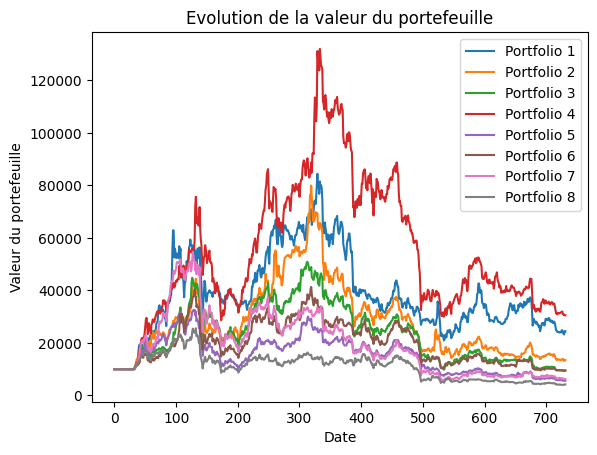

In [ ]:
plt.plot(premier_portefeuille_centralise, label="Portfolio 1")
plt.plot(deuxieme_portefeuille_centralise, label="Portfolio 2")
plt.plot(troisieme_portefeuille_centralise, label="Portfolio 3")
plt.plot(quatrieme_portefeuille_centralise, label="Portfolio 4")
plt.plot(cinquieme_portefeuille_centralise, label="Portfolio 5")
plt.plot(sixieme_portefeuille_centralise, label="Portfolio 6")
plt.plot(septieme_portefeuille_centralise, label="Portfolio 7")
plt.plot(huitieme_portefeuille_centralise, label="Portfolio 8")
plt.title('Evolution de la valeur du portefeuille')
plt.xlabel('Date')
plt.ylabel('Valeur du portefeuille')
plt.legend()    
plt.show()

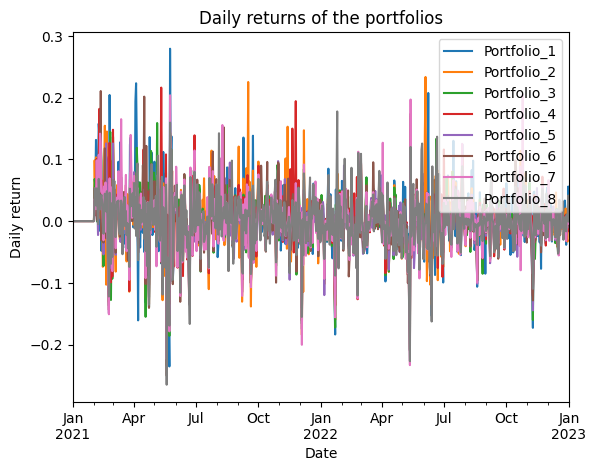

In [ ]:
#creer un dataframe avec les valeurs des portefeuilles centralisés
portfolio_values_dict_centralized = {}
portfolio_values_dict_centralized["Portfolio_1"] = premier_portefeuille_centralise
portfolio_values_dict_centralized["Portfolio_2"] = deuxieme_portefeuille_centralise
portfolio_values_dict_centralized["Portfolio_3"] = troisieme_portefeuille_centralise
portfolio_values_dict_centralized["Portfolio_4"] = quatrieme_portefeuille_centralise
portfolio_values_dict_centralized["Portfolio_5"] = cinquieme_portefeuille_centralise
portfolio_values_dict_centralized["Portfolio_6"] = sixieme_portefeuille_centralise
portfolio_values_dict_centralized["Portfolio_7"] = septieme_portefeuille_centralise
portfolio_values_dict_centralized["Portfolio_8"] = huitieme_portefeuille_centralise

portfolio_values_df_centralized = pd.DataFrame(portfolio_values_dict_centralized)
portfolio_values_df_centralized = portfolio_values_df_centralized.dropna()
portfolio_values_df_centralized = portfolio_values_df_centralized.iloc[1:]
portfolio_values_df_centralized.index = centralized_df.index

portfolio_daily_returns_centralized = portfolio_values_df_centralized.pct_change()
portfolio_daily_returns_centralized.plot(title='Daily returns of the portfolios', xlabel='Date', ylabel='Daily return')
plt.show()


In [ ]:
first_date = data_factors['timestamp'].min()
last_date = portfolio_daily_returns_centralized.index.max()

all_dates = pd.date_range(start=first_date, end=last_date, freq='D')
rf_df = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'RF']], on='timestamp', how='left')
rf_df['RF'].fillna(method='ffill', inplace=True)
rf_df['RF'] = rf_df['RF'].str.replace(',', '.').astype(float)/100 

merged_centralized = portfolio_daily_returns_centralized.merge(rf_df, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_centralized = merged_centralized.loc[rebalancing_dates[0]:]
merged_centralized = merged_centralized.iloc[1:]
variance_merged_centralized = merged_centralized.std()

In [ ]:
#on fait les stats sur les daily return
indicators_centralized = {}

for column in merged_centralized.columns:
    returns = merged_centralized[column]
    result = returns.describe()
    skewness = sm.stats.stattools.robust_skewness(returns)
    kurtosis = sm.stats.stattools.robust_kurtosis(returns)
    
    indicators_centralized[column] = {
        'Mean': result['mean'],
        'Stddev': result['std'],
        'Median': result['50%'],
        'Min': result['min'],
        'Max': result['max'],
        'Skewness': skewness[0],
        'Kurtosis': kurtosis[0]
    }

# Print the indicators for each returns series
for column, values in indicators_centralized.items():
    print(f"Indicators for {column}:")
    for indicator, value in values.items():
        print(f"{indicator}: {value}")
    print()



Indicators for Portfolio_1:
Mean: 0.002454697188429568
Stddev: 0.0486741121665925
Median: 0.0010642270125025277
Min: -0.23544540121652102
Max: 0.27904042829100817
Skewness: 0.37505570215224343
Kurtosis: 4.69404052144982

Indicators for Portfolio_2:
Mean: 0.001572940216647606
Stddev: 0.04788451943424567
Median: 0.0018247325972522432
Min: -0.23399131987880273
Max: 0.23331652234157274
Skewness: 0.019063521484338878
Kurtosis: 3.133868279277012

Indicators for Portfolio_3:
Mean: 0.0008924540749366181
Stddev: 0.0433813057454951
Median: 0.0020872533784028757
Min: -0.20841376790131372
Max: 0.1587259561204637
Skewness: -0.6065628765479024
Kurtosis: 3.2626213017737156

Indicators for Portfolio_4:
Mean: 0.002564257103415396
Stddev: 0.044015824330000765
Median: 0.003082029828009647
Min: -0.17765048739420608
Max: 0.21609208940337776
Skewness: 0.12967272600774368
Kurtosis: 3.0387338256079026

Indicators for Portfolio_5:
Mean: -5.954683553200249e-06
Stddev: 0.04030749666459096
Median: 0.0015233719380

In [ ]:
#on soustrait RF à chaque daily return
merged_centralized['Portfolio_1'] = merged_centralized['Portfolio_1'] - merged_centralized['RF']
merged_centralized['Portfolio_2'] = merged_centralized['Portfolio_2'] - merged_centralized['RF']
merged_centralized['Portfolio_3'] = merged_centralized['Portfolio_3'] - merged_centralized['RF']
merged_centralized['Portfolio_4'] = merged_centralized['Portfolio_4'] - merged_centralized['RF']
merged_centralized['Portfolio_5'] = merged_centralized['Portfolio_5'] - merged_centralized['RF']
merged_centralized['Portfolio_6'] = merged_centralized['Portfolio_6'] - merged_centralized['RF']
merged_centralized['Portfolio_7'] = merged_centralized['Portfolio_7'] - merged_centralized['RF']
merged_centralized['Portfolio_8'] = merged_centralized['Portfolio_8'] - merged_centralized['RF']


### Ratio de sharpe

In [ ]:
#on calcul le ration de sharpe pour chaque portfolio de 1 a 9
sharpe_ratios_portfolios = (merged_centralized.mean()) / variance_merged_centralized.std()
print("Le ratio de sharpe des portefeuilles 1 à 9 :","\n",sharpe_ratios_portfolios[0:8])

Le ratio de sharpe des portefeuilles 1 à 9 : 
 Portfolio_1    0.161781
Portfolio_2    0.103667
Portfolio_3    0.058819
Portfolio_4    0.169001
Portfolio_5   -0.000392
Portfolio_6    0.059077
Portfolio_7    0.028810
Portfolio_8   -0.015848
dtype: float64


### Ratio de Treynor/ alpha de Jensen

In [ ]:
centralized_rf = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF']], on='timestamp', how='left')
centralized_rf['Mkt-RF'].fillna(method='ffill', inplace=True)
centralized_rf['Mkt-RF'] = centralized_rf['Mkt-RF'].str.replace(',', '.').astype(float)/100

merged_centralized_rf = merged_df.merge(centralized_rf, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
merged_centralized_rf = merged_centralized_rf.loc[rebalancing_dates[0]:]
merged_centralized_rf = merged_centralized_rf.iloc[1:]

merged_centralized_rf.head()

,Portfolio_1,Portfolio_2,Portfolio_3,Portfolio_4,Portfolio_5,Portfolio_6,Portfolio_7,Portfolio_8,Portfolio_9,RF,Mkt-RF
timestamp,,,,,,,,,,,
2021-02-03,0.060593,0.041370,0.056166,0.039222,0.024428,0.026546,0.023094,0.054111,0.044119,0.0,0.0015
2021-02-04,0.131356,0.082706,0.041686,0.030821,0.025813,0.033574,0.018965,0.012805,0.009756,0.0,0.0123
2021-02-05,0.026753,0.080680,0.121114,0.075505,0.080087,0.067547,0.073394,0.036248,0.063519,0.0,0.0058
2021-02-06,0.068679,0.027178,-0.001297,-0.030620,0.048970,0.013618,-0.001443,0.063680,0.002718,0.0,0.0058
2021-02-07,0.078834,0.002044,0.001293,-0.009741,-0.009109,-0.000523,0.006110,-0.014703,0.021444,0.0,0.0058


### Regression pour obtenir les betas et alphas de Jensen

In [ ]:

# Perform the regression for each portfolio
for portfolio_index in range(1, 10):
    # Select the portfolio values and the Mkt-RF column
    X = merged_centralized_rf['Mkt-RF']
    y = merged_centralized_rf[f'Portfolio_{portfolio_index}']
    
    # Add a constant term to the independent variable
    X = sm.add_constant(X)
    
    # Fit the linear regression model
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Get the intercept (alpha) and slope (beta) coefficients
    alpha_centralized = results.params[0]
    beta_centralized = results.params[1]
    
    # Print the alpha and beta coefficients
    print(f'Portfolio_{portfolio_index}:')
    print(f'Alpha (Jensen): {alpha}')
    print(f'Beta (Market): {beta}')
    print()

Portfolio_1:
Alpha (Jensen): 0.00027524822401817187
Beta (Market): 1.0149892352695993

Portfolio_2:
Alpha (Jensen): 0.00027524822401817187
Beta (Market): 1.0149892352695993

Portfolio_3:
Alpha (Jensen): 0.00027524822401817187
Beta (Market): 1.0149892352695993

Portfolio_4:
Alpha (Jensen): 0.00027524822401817187
Beta (Market): 1.0149892352695993

Portfolio_5:
Alpha (Jensen): 0.00027524822401817187
Beta (Market): 1.0149892352695993

Portfolio_6:
Alpha (Jensen): 0.00027524822401817187
Beta (Market): 1.0149892352695993

Portfolio_7:
Alpha (Jensen): 0.00027524822401817187
Beta (Market): 1.0149892352695993

Portfolio_8:
Alpha (Jensen): 0.00027524822401817187
Beta (Market): 1.0149892352695993

Portfolio_9:
Alpha (Jensen): 0.00027524822401817187
Beta (Market): 1.0149892352695993



### Ratio de Treynor

In [ ]:

#on calcul le ration de sharpe pour chaque portfolio de 1 a 9
treynor_ratios_portfolios = (merged_centralized_rf.mean()) / beta_centralized
print("Le ratio de treynor des portefeuilles 1 à 9 sont :","\n",treynor_ratios_portfolios[0:8])

Le ratio de treynor des portefeuilles 1 à 9 sont : 
 Portfolio_1    0.002357
Portfolio_2    0.001366
Portfolio_3    0.000796
Portfolio_4    0.002169
Portfolio_5    0.000901
Portfolio_6    0.000763
Portfolio_7    0.000041
Portfolio_8   -0.000380
dtype: float64


### Simulation de FAMA & FRENCH

In [112]:
fm_centralized = pd.DataFrame({'timestamp': all_dates}).merge(data_factors[['timestamp', 'Mkt-RF','HML','SMB']], on='timestamp', how='left')
fm_centralized['Mkt-RF'].fillna(method='ffill', inplace=True)
fm_centralized['Mkt-RF'] = fm_centralized['Mkt-RF'].str.replace(',', '.').astype(float)/100
fm_centralized['HML'].fillna(method='ffill', inplace=True)
fm_centralized['HML'] = fm_centralized['HML'].str.replace(',', '.').astype(float)/100
fm_centralized['SMB'].fillna(method='ffill', inplace=True)
fm_centralized['SMB'] = fm_centralized['SMB'].str.replace(',', '.').astype(float)/100

fm_centralized = merged_df.merge(fm_centralized, left_index=True, right_on='timestamp', how='left').set_index('timestamp')
fm_centralized = fm_centralized.loc[rebalancing_dates[0]:]
fm_centralized.head()


,Portfolio_1,Portfolio_2,Portfolio_3,Portfolio_4,Portfolio_5,Portfolio_6,Portfolio_7,Portfolio_8,Portfolio_9,RF,Mkt-RF,HML,SMB
timestamp,,,,,,,,,,,,,
2021-02-02,0.021151,0.110044,0.063678,0.034783,0.030922,0.061237,0.024386,0.047010,0.018269,0.0,0.0148,-0.0108,-0.0085
2021-02-03,0.060593,0.041370,0.056166,0.039222,0.024428,0.026546,0.023094,0.054111,0.044119,0.0,0.0015,0.0070,0.0043
2021-02-04,0.131356,0.082706,0.041686,0.030821,0.025813,0.033574,0.018965,0.012805,0.009756,0.0,0.0123,0.0037,0.0038
2021-02-05,0.026753,0.080680,0.121114,0.075505,0.080087,0.067547,0.073394,0.036248,0.063519,0.0,0.0058,-0.0047,0.0107
2021-02-06,0.068679,0.027178,-0.001297,-0.030620,0.048970,0.013618,-0.001443,0.063680,0.002718,0.0,0.0058,-0.0047,0.0107


In [113]:

# Select the independent variables (Mkt-RF, SMB, HML)
X = fm_centralized[['Mkt-RF', 'SMB', 'HML']]

# Select the dependent variables (portfolio returns)
y = fm_centralized[['Portfolio_1', 'Portfolio_2', 'Portfolio_3', 'Portfolio_4', 'Portfolio_5', 'Portfolio_6', 'Portfolio_7', 'Portfolio_8']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Select each portfolio as a dependent variable and perform OLS regression
coefficients = {}
alphas = {}

for portfolio in y.columns:
    # Select the current portfolio as the dependent variable
    current_y = y[portfolio]

    # Perform OLS regression
    model = sm.OLS(current_y, X)
    results = model.fit()

    # Get the coefficients
    Bmarket = results.params['Mkt-RF']
    Bsmb = results.params['SMB']
    Bhml = results.params['HML']

    # Get the alpha (intercept)
    alpha = results.params['const']

    # Store coefficients and alpha in dictionaries
    coefficients[portfolio] = {'Bmarket': Bmarket, 'Bsmb': Bsmb, 'Bhml': Bhml}
    alphas[portfolio] = alpha

# Print the coefficients and alphas for each portfolio
print("Coefficients:")
for portfolio, coeffs in coefficients.items():
    print(f"{portfolio}: Bmarket={coeffs['Bmarket']}, Bsmb={coeffs['Bsmb']}, Bhml={coeffs['Bhml']}")

print("\nAlphas:")
for portfolio, alpha in alphas.items():
    print(f"{portfolio}: Alpha={alpha}")


Coefficients:
Portfolio_1: Bmarket=0.961501598136943, Bsmb=0.3386565420854252, Bhml=0.1523865755762788
Portfolio_2: Bmarket=0.8988204026970165, Bsmb=-0.003076044116250784, Bhml=0.06741455974486985
Portfolio_3: Bmarket=0.7401957600397763, Bsmb=0.00881385068594252, Bhml=0.030466685721396217
Portfolio_4: Bmarket=0.7762491242776941, Bsmb=-0.12414204804965315, Bhml=0.06725971211621647
Portfolio_5: Bmarket=0.6892136830344119, Bsmb=0.1484986630421088, Bhml=0.0405720089702994
Portfolio_6: Bmarket=0.7970888501534195, Bsmb=-0.15314776212462597, Bhml=-0.02078956105174091
Portfolio_7: Bmarket=0.9427518630452788, Bsmb=-0.0814378599373918, Bhml=-0.0072823761154558134
Portfolio_8: Bmarket=0.9407711446358734, Bsmb=-0.24642929482987236, Bhml=0.016681216833179163

Alphas:
Portfolio_1: Alpha=0.00212010236296028
Portfolio_2: Alpha=0.0012739655921453897
Portfolio_3: Alpha=0.0007031946612244024
Portfolio_4: Alpha=0.0019741209628696224
Portfolio_5: Alpha=0.0007924769581651453
Portfolio_6: Alpha=0.00067868678